# Variational classifier with PennyLane

This is a [Xanadu tutorial](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) for PennyLane's library wich has the purpose to implement a variational quantum classifier. Here we will train a quantum circuit with labelled data and then use it to classify new data.

It can be shown that de variational quantum classifier can reproduce the parity function

$$f : x\in \{0,1\} ^{\otimes n} \rightarrow y = \left\{\begin{array}{lll}
1& \text{if uneven number of ones in } x\\
0 &\text{otherwise}
\end{array} \right.$$

I think this parity function is not unique, so then we could construct the function depending on what we would like to classify.

Here it is shown how to encode real vectors as amplitud vectors, this is called amplitude encoding, and with this we can train the model to recognize the first two classes of flowers in the Iris dataset.

--------

We begin by importing the libraries

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [2]:
# We now initialice a quantum circuit with 4 qubits
dev = qml.device("default.qubit", wires = 4)

Now we have to define our layer or block. This is an elementary circuit architecture that is repeated to build the variational circuit. This layers can be modified according on what we need. The Layer proposed in this guide consist on arbitrary rotations on each qubit as well as CNOT gates that entangle each qubit with its neightbours.

In [3]:
def layer(W):
    #qml.Rot(\phi,\theta,\omega,wire)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

Now we have to find the way to encode data inputs $x$ into the circuit, then, we have to define a quantum state of qubits which represents the $x$ imput. In this case the inputs are bitstrings, so directly they define
$$ x = 0101 \rightarrow |\psi\rangle = |0101\rangle $$
There is a function called BasisState. Which prepares n wires in a given list of zeros and ones.

In [4]:
def statePreparation(x):
    #x is a np.array, for example [0,0,1,1]
    #the function prepares the wires in the state |0011>
    
    qml.BasisState(x, wires=[0, 1, 2, 3])

Now a Qnode is defined as a routine for the state preparation, followed by a repetition of the layer structure. So, given a determined amount of weights (which are the analogous of the $\theta$ parameters) the layer is repeated using each of this weights.

In [5]:
@qml.qnode(dev)
def circuit(weights,x):
    
    
    statePreparation(x)
    
    for W in weights:
        layer(W)
        
    return qml.expval(qml.PauliZ(0))

In this case we are giving to the Qnode the data as a keyword argument x. This Keyword arguments are fixed when calculating a gradient, this means that the traning is done over the weights!!

Also we can add a "classical" bias, this is the amount of error from the algorithm to predict some value, it is important to take into account that low bias does not necessarily means that the algorithm is good, since when there is an overfitted algorithm the bias tends to 0. So now we built up the classifier, var will have the variables that we need, this is the weights and the bias, then we put all together in the ciruit to generate the classification. 

In [6]:
def variational_classifier(var, x):
    
    weights = var[0]
    bias = var[1]
    return circuit(weights, x) + bias


## Cost

Now we calculate the cost function or the Residual Sum Squares (RSS), this is the parameter that shows the error between the predicted and the real value of a datapoint first we calculate the swuare loss between real labels and predictions

In [7]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

Now we can define de accuracy function, this function will give us the percentage of correctly predicted labels 


In [8]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss
    

Now we calculate the cost function as the square loss between the real labels and the predictions from the algorithm

In [9]:
def cost(var, X, Y):
    predictions = [variational_classifier(var, x) for x in X]
    return square_loss(Y, predictions)


# Optimization

Here we are going to load the data from the file `variational_classifier/data/parity.txt`. This data has five columns where, the first four contain the information of the stat, this means the $x$ that we define earlier, and the fifth column is $1$ if $x$ has an uneven numer of ones or $0$ otherwise 

In [10]:
data = np.loadtxt("variational_classifier/data/parity.txt")
X = np.array(data[:, :-1], requires_grad=False)
Y = np.array(data[:, -1], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")

X = [0. 0. 0. 0.], Y = -1
X = [0. 0. 0. 1.], Y =  1
X = [0. 0. 1. 0.], Y =  1
X = [0. 0. 1. 1.], Y = -1
X = [0. 1. 0. 0.], Y =  1
...


Now we initialize random variables in order to test the algorithm. Here we generate random numbers where the first one is the bias and the other are going to be the weights.

In [11]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

print(var_init)

(tensor([[[ 0.01764052,  0.00400157,  0.00978738],
         [ 0.02240893,  0.01867558, -0.00977278],
         [ 0.00950088, -0.00151357, -0.00103219],
         [ 0.00410599,  0.00144044,  0.01454274]],

        [[ 0.00761038,  0.00121675,  0.00443863],
         [ 0.00333674,  0.01494079, -0.00205158],
         [ 0.00313068, -0.00854096, -0.0255299 ],
         [ 0.00653619,  0.00864436, -0.00742165]]], requires_grad=True), 0.0)


Next step is to create the optimizer, this is provide by PannyLane as  [`NesterovMomentumOptimizer`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.NesterovMomentumOptimizer.html#pennylane.NesterovMomentumOptimizer). This is a class that optimize the gradien-descent algorithm using what is called the Nesterov momentum. Then we define the batch_size and train the optimizer.

In [12]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

Here we are going to look at the accuracy of the algorithm, taking the correctly classified data. For this we first compute what should be the correct output and then we take the prediction as follows

In [13]:
var = var_init

for it in range(35):
        
        batch_index = np.random.randint(0, len(X), (batch_size,))
        # Take 5 random arrays of x, i.e. the form [0,1,0,0]
        X_batch = X[batch_index]
        
        # Has the answers of the previous x
        Y_batch = Y[batch_index]
        
        # Computes the cost function in order to optimize it
        var = opt.step(lambda v: cost(v, X_batch, Y_batch), var)
        
        # Compute the accuracy
        predictions = [np.sign(variational_classifier(var, x)) for x in X]
        acc = accuracy(Y, predictions)

        
        print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(var, X, Y), acc
        )
        )
        

Iter:     1 | Cost: 3.4355534 | Accuracy: 0.5000000 
Iter:     2 | Cost: 1.9287800 | Accuracy: 0.5000000 
Iter:     3 | Cost: 2.0341238 | Accuracy: 0.5000000 
Iter:     4 | Cost: 1.6372574 | Accuracy: 0.5000000 
Iter:     5 | Cost: 1.3025395 | Accuracy: 0.6250000 
Iter:     6 | Cost: 1.4555019 | Accuracy: 0.3750000 
Iter:     7 | Cost: 1.4492786 | Accuracy: 0.5000000 
Iter:     8 | Cost: 0.6510286 | Accuracy: 0.8750000 
Iter:     9 | Cost: 0.0566074 | Accuracy: 1.0000000 
Iter:    10 | Cost: 0.0053045 | Accuracy: 1.0000000 
Iter:    11 | Cost: 0.0809483 | Accuracy: 1.0000000 
Iter:    12 | Cost: 0.1115426 | Accuracy: 1.0000000 
Iter:    13 | Cost: 0.1460257 | Accuracy: 1.0000000 
Iter:    14 | Cost: 0.0877037 | Accuracy: 1.0000000 
Iter:    15 | Cost: 0.0361311 | Accuracy: 1.0000000 
Iter:    16 | Cost: 0.0040937 | Accuracy: 1.0000000 
Iter:    17 | Cost: 0.0004899 | Accuracy: 1.0000000 
Iter:    18 | Cost: 0.0005290 | Accuracy: 1.0000000 
Iter:    19 | Cost: 0.0024304 | Accuracy: 1.00

As you can see, the cost function which is related to the diference between the predictions and the true labels decrease along the iterations, showing that the algorithm is effectively making better predictions each time. Also we can see the accuracy increasing, showing us, again, that the algorithm is working.

# Iris classification

Here we'll be able to encode real-valued vectors into quantum states. This technique is frequantly used for representing images or real data as quantum states. We are going to use a 2-qubit simulator.

In [14]:
dev = qml.device("default.qubit", wires = 2)

The vector that contains the information to be classified will be encoded using what we known as amplitude enconding. Here se vector $\mathbf{x} = (x_1,x_2,...,x_n)$ is encoded into a quantum state $|x> = x_1|e_1> + x_2 |e_2> + ... + x_n|e_n>$, with $|e_i>$ basis of a Hilbert space with the necessary dimension to encode $\mathbf{x}$. This can be done using the technique employed by [Schuld and Petruccione](https://link.springer.com/book/10.1007/978-3-319-96424-9). To do this, we think about the state $|x>$ and look for a transformation which $|x> \rightarrow |e_1>$ then we invert this transformatios to have $|e_1> \rightarrow |x>$ so we can take the standard initial state of the n qubits into the desire $|x>$ state. This can be seen in more detail in [Möttönen, et al.](https://arxiv.org/pdf/quant-ph/0407010.pdf).

In [17]:
## First, the angles of the transformation

def get_angles(x):
    
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

The previous function give the rotation angles and prepare the state in orted to encode a vector $\mathbf{x}$ in its amplitudes respectively. Lets see if it works.

In [19]:
x = np.array([0.5, 0.5, 0.5, 0.5], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev.state))

x               :  [0.5 0.5 0.5 0.5]
angles          :  [ 1.57079633 -0.78539816  0.78539816 -0.78539816  0.78539816]
amplitude vector:  [0.5 0.5 0.5 0.5]


It works! the default.qubit simulatiors provides a function for doing this initialization, however, it is important to know how it is made.

Now we modify our previous layer for one with 2 qubits.

In [20]:
 def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

The cost and the variational classifier remain the same, we just have to reload them using the new layer

In [21]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(var, angles):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles) + bias


def cost(weights, features, labels):
    predictions = [variational_classifier(weights, f) for f in features]
    return square_loss(labels, predictions)

## Data

Now we load the Iris data set which is in the folder `variational_classifier/data`. This is a dataset of two dimmensional vectors, we will pad this into 4 dimensional vectorss and then we are going to normalize it.


In [39]:
data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


The new features are the angles, which are the ones to be taken into account for the classification. Lets graph some of the previous vectors and see what we have done,

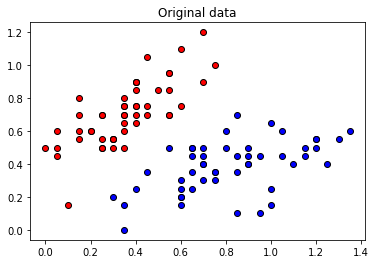

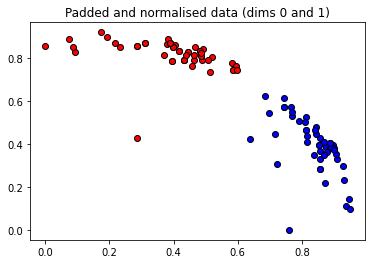

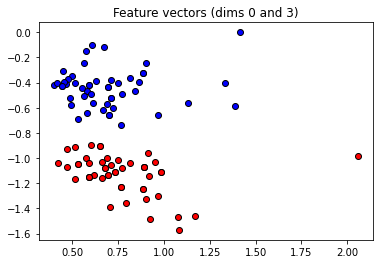

In [40]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

Now we split up the data into a train and validation set

In [41]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

## Optimization

Again, lets set the number of qubits, number of layer and initial values of the optimicer

In [42]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

Now we optimize the cost function

In [43]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
var = var_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.4490948 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.3309953 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.1582178 | Acc train: 0.4533333 | Acc validation: 0.5600000 
Iter:     4 | Cost: 0.9795035 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 0.8857893 | Acc train: 0.6400000 | Acc validation: 0.7600000 
Iter:     6 | Cost: 0.8587935 | Acc train: 0.7066667 | Acc validation: 0.7600000 
Iter:     7 | Cost: 0.8496204 | Acc train: 0.7200000 | Acc validation: 0.6800000 
Iter:     8 | Cost: 0.8200972 | Acc train: 0.7333333 | Acc validation: 0.6800000 
Iter:     9 | Cost: 0.8027511 | Acc train: 0.7466667 | Acc validation: 0.6800000 
Iter:    10 | Cost: 0.7695152 | Acc train: 0.8000000 | Acc validation: 0.7600000 
Iter:    11 | Cost: 0.7437432 | Acc train: 0.8133333 | Acc validation: 0.9600000 
Iter:    12 | Cost: 0.7569196 | Acc train: 0.6800000 | Acc validation: 0.7600000 
Iter:    13 | Co

The classifier is working properly since we can see how the cost function is being reduced. Now we plot the decisión regions and the classified data

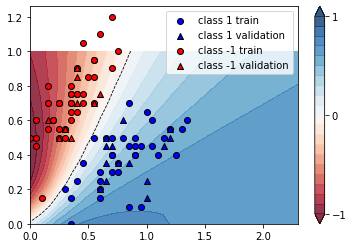